# 02. In-Depth Detection and Grading

In this tutorial, we dive into the interior of SpineNet, debugging some missed detections. Begin by loading in SpineNet as in `01-quickstart.ipynb` and then detecting vertebrae in each scan.

example_scans/temp_file.zip: 100%|██████████| 1.60M/1.60M [00:00<00:00, 62.8MiB/s]
/users/rhydian/anaconda3/envs/default_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/users/rhydian/anaconda3/envs/default_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loading Detection Model...
==> Loading model trained for 436 epochs...
Loading Appearance Model...
==> Loading model trained for 188 epochs...
Loading Context Model...
==> Loading model trained for 17 epochs...
Loading Grading Model...
==> Loading model trained for 2 epochs...


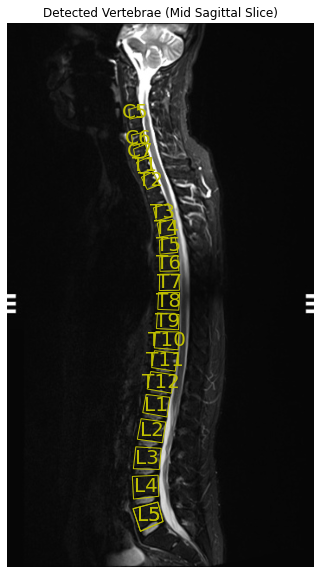

In [1]:
import sys
import os
from pathlib import Path
sys.path.insert(0, str(Path(os.getcwd()).parent)) # Add parent directory to path. This shouldn't be needed if SpineNet is pip-installed



import spinenet
from spinenet import SpineNet, download_example_scan
from spinenet.io import load_dicom_from_folder

# download example scans 
os.makedirs('example_scans', exist_ok=True)

# load in example whole spine stir scan
example_scan_folder = 'example_scans/stir_whole_spine'
download_example_scan('stir_whole_spine', file_path='example_scans')

# load in spinenet. Replace device with 'cpu' if you are not using a CUDA-enabled machine.
spnt = SpineNet(device='cuda:0', verbose=True)

# metadata to be overwritten in the scan - useful if certain important values are missing from some/all dicom files
# in this case, slice thickness and image orientation are missing from the dicom files and so we add false values
# of 2mm and a sagittal orientation code ([0,1,0,0,0,1]). 
# Do not overwrite this metadata if it already exists in the dicom files being used.
overwrite_dict = {'SliceThickness': [2], 'ImageOrientationPatient': [0, 1, 0, 0, 0, -1]}


# loads in a dicom from the example scan folder.
# if set, the `require_extensions` flag requires that files end with `.dcm`
scan = load_dicom_from_folder(example_scan_folder, require_extensions=False, metadata_overwrites=overwrite_dict)



# detect and identify vertebrae in scan. Note that pixel spacing information is required 
# so SpineNet knows what size to split patches into.
vert_dicts = spnt.detect_vb(scan.volume, scan.pixel_spacing)

# now show results
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
# plot mid sagittal slice and detected vertebrae
plt.figure(figsize=(10,10))
plt.imshow(scan.volume[:,:,scan.volume.shape[-1]//2], cmap='gray')
for idx, vert_dict in enumerate(vert_dicts):
    # if scan.volume.shape[-1]//2 in vert_dict['slice_nos']:
    poly = np.array(vert_dict['average_polygon'])
    plt.gca().add_patch(Polygon(poly, fc='none', ec='y'))
    plt.text(np.mean(poly[:,0]), np.mean(poly[:,1]), vert_dict['predicted_label'], color='y',fontsize=20, va='center', ha='center')

plt.axis('off')
plt.title('Detected Vertebrae (Mid Sagittal Slice)')
plt.show()


Now as can be seen from above, this scan has some missing detections. In fact, this is because the uploaded scan's metadata is faulty (it's PixelSpacing header reads 0.5mm, which would make the whole scan 355*.5mm=17.7 cm across. Clearly this is wrong!)
Instead of fixing this right away, let's see what happens in the SpineNet processing pipeline when this error occurs.

SpineNet begins by splitting the scan exhaustively into 26x26cm patches, as can be seen in the `SpineNet.detect_vb` function. Specifically the function `SpineNet.utils.scan_preprocessing.split_patches_exhaustive` does this. Let's look at the patches made.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


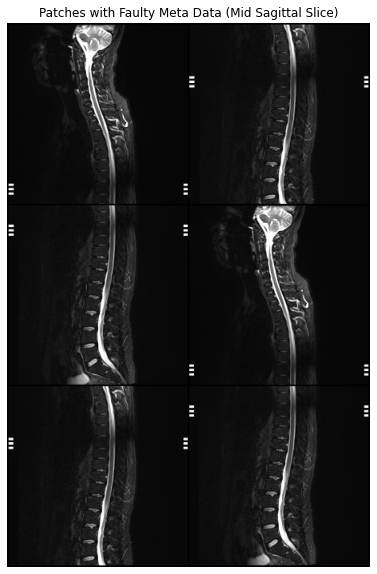

In [2]:
import torch
from torchvision.utils import make_grid
from spinenet.utils.scan_preprocessing import split_into_patches_exhaustive

patches, _ = split_into_patches_exhaustive(scan.volume, scan.pixel_spacing)

grid = make_grid(torch.stack(patches[scan.volume.shape[-1]//2]).unsqueeze(1), nrow=np.sqrt(len(patches[scan.volume.shape[-1]//2])).astype(int)) 



plt.figure(figsize=(10,10))
plt.imshow(grid.permute(1,2,0))
plt.title('Patches with Faulty Meta Data (Mid Sagittal Slice)')
plt.axis('off')
plt.show()



Clearly these patches are too big, and so SpineNet struggles to detect vertebrae at the top of the spine. Therefore, let's change the metadata and see if that fixes things.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


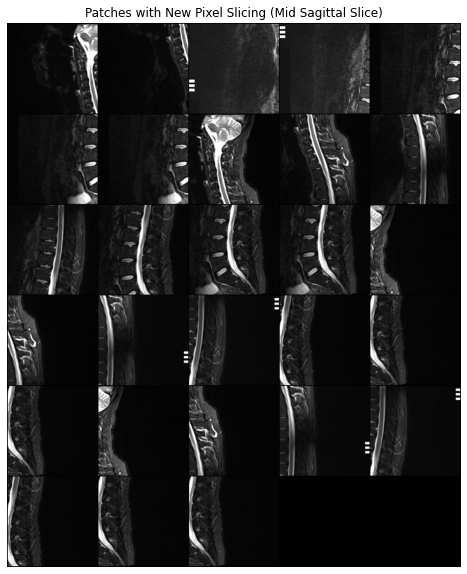

In [3]:
new_pixel_spacing = 1.5 # (1.5mm pixel spacing makes the whole scan about 55cm across which looks plausible)

patches, _ = split_into_patches_exhaustive(scan.volume, new_pixel_spacing)
grid = make_grid(torch.stack(patches[scan.volume.shape[-1]//2]).unsqueeze(1), nrow=np.sqrt(len(patches[scan.volume.shape[-1]//2])).astype(int)) 
plt.figure(figsize=(10,10))
plt.imshow(grid.permute(1,2,0))
plt.title('Patches with New Pixel Slicing (Mid Sagittal Slice)')
plt.axis('off')
plt.show()


These patches look a lot more reasonable! Let's see if it improves the detections? 

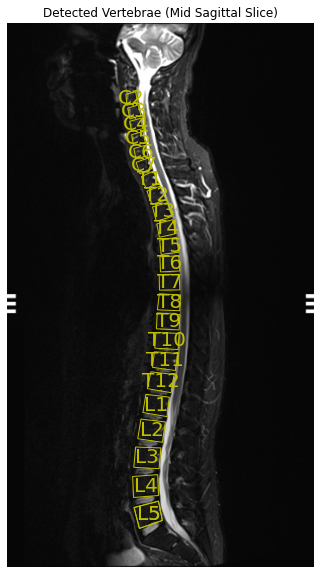

In [4]:
# detect and identify vertebrae in scan. Note that pixel spacing information is required 
# so SpineNet knows what size to split patches into.
vert_dicts = spnt.detect_vb(scan.volume, new_pixel_spacing)

# now show results
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
# plot mid sagittal slice and detected vertebrae
plt.figure(figsize=(10,10))
plt.imshow(scan.volume[:,:,scan.volume.shape[-1]//2], cmap='gray')
for idx, vert_dict in enumerate(vert_dicts):
    # if scan.volume.shape[-1]//2 in vert_dict['slice_nos']:
    poly = np.array(vert_dict['average_polygon'])
    plt.gca().add_patch(Polygon(poly, fc='none', ec='y'))
    plt.text(np.mean(poly[:,0]), np.mean(poly[:,1]), vert_dict['predicted_label'], color='y',fontsize=20, va='center', ha='center')

plt.axis('off')
plt.title('Detected Vertebrae (Mid Sagittal Slice)')
plt.show()

Much better! Often, even if the metadata is correct, detections can be improved by slightly changing the pixel spacing.

However, SpineNet is still missing S1. To find out why this is, we can look at detections within each patch. This can be done by passing the `debug=True` flag to `spinenet.detect_vb` and then examining the `patches_dict` object.
We can then show the heatmaps used to detect landmarks in each patch.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


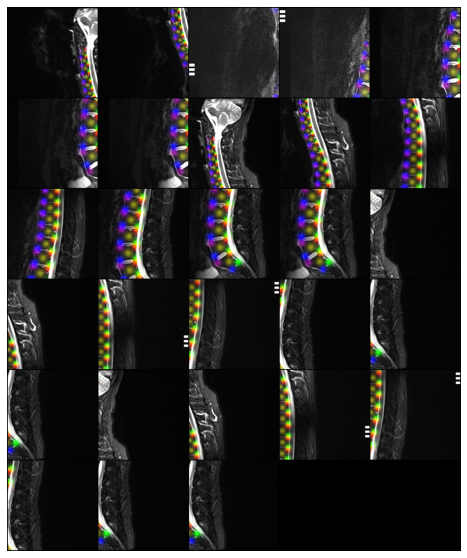

In [5]:
vert_dicts, patches, patches_dicts, detection_dicts, transform_info, _,_,_,_ = spnt.detect_vb(scan.volume, new_pixel_spacing, debug=True)

def grayscale(x):
    val = np.stack([x,x,x], axis=-1)
    return val/val.max()
def red(x):
    y = np.zeros_like(x)
    return np.stack([x,y,y], axis=-1)

def green(x):
    y = np.zeros_like(x)
    return np.stack([y,x,y], axis=-1)

def blue(x):
    y = np.zeros_like(x)
    return np.stack([y,y,x], axis=-1)

def pink(x):
    return (red(x) + blue(x))/2

def orange(x):
    return (red(x) + green(x))/2

slice_patches_dict = patches_dicts[scan.volume.shape[-1]//2]
# print(slice_patches_dict['patches'].shape)

grid = make_grid(torch.from_numpy(slice_patches_dict['patches']), nrow=np.sqrt(len(slice_patches_dict['patches'])).astype(int)).permute(1,2,0)

for idx,color_fn in enumerate([red, green, blue, pink, orange]):
    landmark_heatmap = torch.Tensor(slice_patches_dict['net_output'][:,idx][:,None])
    landmark_grid = color_fn(make_grid(landmark_heatmap, nrow=np.sqrt(len(slice_patches_dict['patches'])).astype(int)).permute(1,2,0)[:,:,0])
    grid += landmark_grid

plt.figure(figsize=(10,10))
plt.imshow(grid)
plt.axis('off')
plt.show()

We can also show the landmarks after the channels have been post-processed.

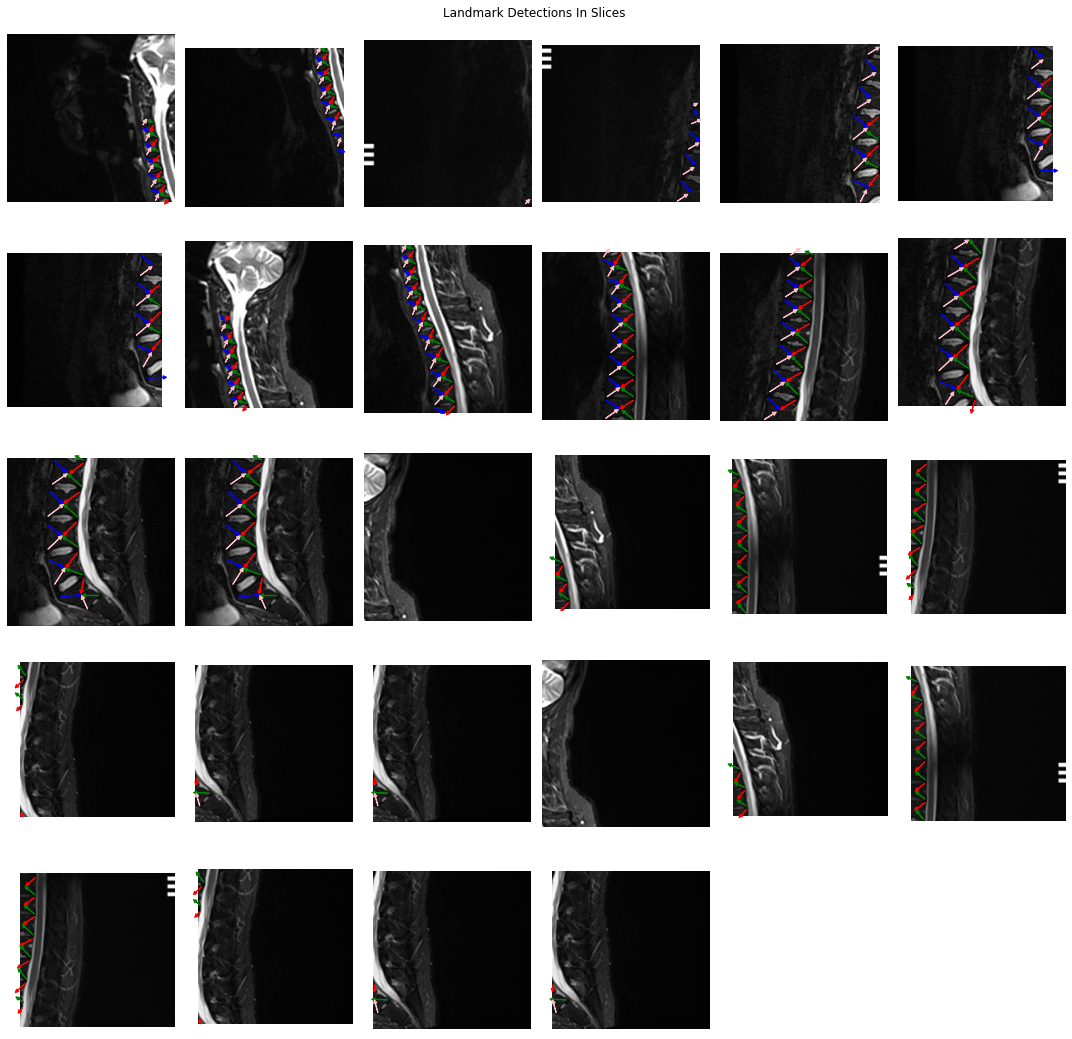

In [6]:

plt.figure(figsize=(15,15))


colors = ['red','green','blue','pink','orange']
for idx, patch in enumerate(slice_patches_dict['patches']):
    plt.subplot(5,6,idx+1)  
    plt.imshow(grayscale(patch[0]), cmap='gray')
    plt.axis('off')
    # plot each of the landmarks
    for landmark_type_idx, landmark_type in enumerate(['rt','rb','lt','lb']):
        for landmark_idx, landmark in enumerate(slice_patches_dict['landmark_points'][landmark_type][idx]):
            arrow = slice_patches_dict['landmark_arrows'][landmark_type][idx][landmark_idx]
            plt.arrow(landmark[1], landmark[0], arrow[1], arrow[0], color=colors[landmark_type_idx], width=0.5, head_width=5, head_length=5, length_includes_head=True)
plt.suptitle('Landmark Detections In Slices ')
plt.tight_layout()
            

These landmarks are then transformed back into the frame of the original scan and then grouped into polygons. We can see these polygons in each slice by looking at the `detection_dicts` object 

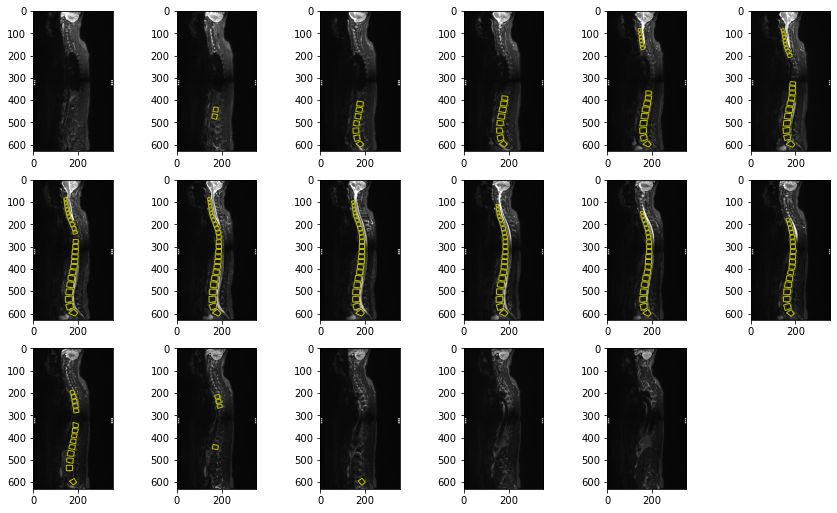

In [7]:

plt.figure(figsize=(15,15))
for slice_idx, x in enumerate(detection_dicts):
    plt.subplot(5,6,slice_idx+1)
    plt.imshow(scan.volume[:,:,slice_idx], cmap='gray')
    for poly_idx, poly in enumerate(x['detection_polys']):
        plt.gca().add_patch(Polygon(poly, fc='none', ec='y'))
plt.show()
